## Step 0: Importing Libraries

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from tensorflow.python.keras.layers import Dense, Input, Conv2D, Flatten, Reshape, Conv2DTranspose
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.python.keras.datasets import cifar10
from tensorflow.python.keras.utils import plot_model
from tensorflow.python.keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import os


## Step 1: Load Data

In [0]:
# convert from color image (RGB) to grayscale
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

In [3]:
# load the CIFAR10 data
(x_train, _), (x_test, _) = cifar10.load_data()
# input image dimensions

img_rows = x_train.shape[1]
img_cols = x_train.shape[2]
channels = x_train.shape[3]

imgs_dir = 'saved_images'
save_dir = os.path.join(os.getcwd(), imgs_dir)
if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
        


170500096/170498071 [==============================] - 16s 0us/step


In [4]:
x_train.shape

(50000, 32, 32, 3)

In [5]:
imgs = x_test[:100]
imgs.shape

(100, 32, 32, 3)

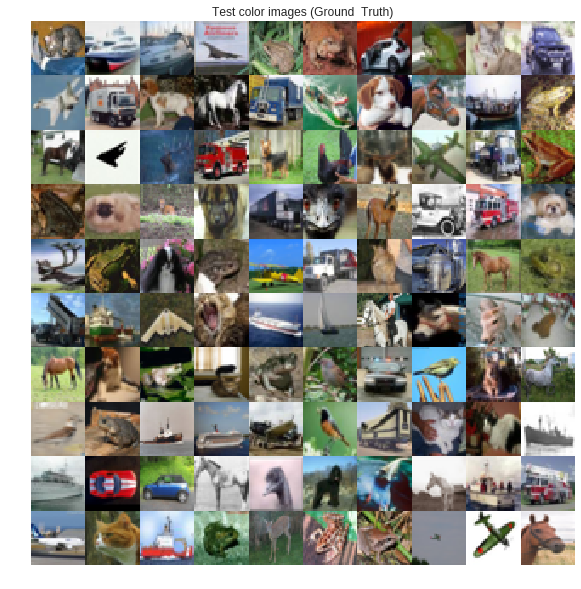

In [6]:

imgs = imgs.reshape((10, 10, img_rows, img_cols, channels))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure(figsize=(20,10))
plt.axis('off')
plt.title('Test color images (Ground  Truth)')
plt.imshow(imgs, interpolation='none')
plt.savefig('%s/test_color.png' % imgs_dir)
plt.show()

In [0]:
x_train_gray = rgb2gray(x_train)
x_test_gray = rgb2gray(x_test)

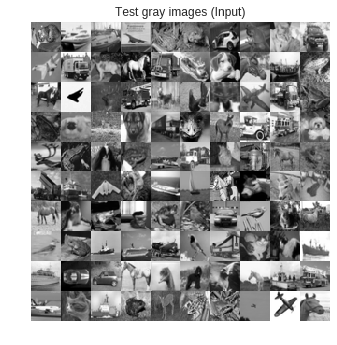

In [8]:
imgs = x_test_gray[:100]
imgs = imgs.reshape((10, 10, img_rows, img_cols))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Test gray images (Input)')
plt.imshow(imgs, interpolation='none', cmap='gray')
plt.savefig('%s/test_gray.png' % imgs_dir)
plt.show()

## Step 2: Preprocessing Image Data

In [0]:

# normalize output train and test color images
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# normalize input train and test grayscale images
x_train_gray = x_train_gray.astype('float32') / 255
x_test_gray = x_test_gray.astype('float32') / 255

In [0]:
# reshape images to row x col x channel for CNN output/validation
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, channels)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, channels)

# reshape images to row x col x channel for CNN input
x_train_gray = x_train_gray.reshape(x_train_gray.shape[0], img_rows, img_cols, 1)
x_test_gray = x_test_gray.reshape(x_test_gray.shape[0], img_rows, img_cols, 1)

## Step 3: Defining Encoder Model Architecture

In [0]:
input_shape = (img_rows, img_cols, 1)
batch_size = 32
kernel_size = 3
latent_dim = 256
# encoder/decoder number of CNN layers and filters per layer
layer_filters = [64, 128, 256]

# build the autoencoder model
# first build the encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
# stack of Conv2D(64)-Conv2D(128)-Conv2D(256)
for filters in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=2,
               activation='relu',
               padding='same')(x)

In [0]:
# shape info needed to build decoder model so we don't do hand computation
# the input to the decoder's first Conv2DTranspose will have this shape
# shape is (4, 4, 256) which is processed by the decoder back to (32, 32, 3)
shape = K.int_shape(x)

In [22]:
# generate a latent vector
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

# instantiate encoder model
encoder = Model(inputs, latent, name='encoder')
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 64)        640       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 4, 4, 256)         295168    
_________________________________________________________________
flatten_2 (Flatten)          (None, 4096)              0         
_________________________________________________________________
latent_vector (Dense)        (None, 256)               1048832   
Total params: 1,418,496
Trainable params: 1,418,496
Non-trainable params: 0
_________________________________________________________________


## Step 4: Defining Decoder Architecture

In [0]:

# build the decoder model
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
x = Dense(shape[1]*shape[2]*shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

In [24]:
# stack of Conv2DTranspose(256)-Conv2DTranspose(128)-Conv2DTranspose(64)
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        strides=2,
                        activation='relu',
                        padding='same')(x)

outputs = Conv2DTranspose(filters=channels,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 4096)              1052672   
_________________________________________________________________
reshape_2 (Reshape)          (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 8, 8, 256)         590080    
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 16, 16, 128)       295040    
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 32, 32, 64)        73792     
_________________________________________________________________
decoder_output (Conv2DTransp (None, 32, 32, 3)         1731      
Total para

## Step 5: Defining Autoencoder Architecture

In [25]:
# autoencoder = encoder + decoder
# instantiate autoencoder model
autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
autoencoder.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 32, 32, 1)         0         
_________________________________________________________________
encoder (Model)              (None, 256)               1418496   
_________________________________________________________________
decoder (Model)              (None, 32, 32, 3)         2013315   
Total params: 3,431,811
Trainable params: 3,431,811
Non-trainable params: 0
_________________________________________________________________


## Step 6: Training Model

In [0]:
# prepare model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'colorized_ae_model.{epoch:03d}.h5'
if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

In [0]:
# reduce learning rate by sqrt(0.1) if the loss does not improve in 5 epochs
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               verbose=1,
                               min_lr=0.5e-6)

# save weights for future use (e.g. reload parameters w/o training)
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True)

# Mean Square Error (MSE) loss function, Adam optimizer
autoencoder.compile(loss='mse', optimizer='adam')


In [28]:
# called every epoch
callbacks = [lr_reducer, checkpoint]

# train the autoencoder
autoencoder.fit(x_train_gray,
                x_train,
                validation_data=(x_test_gray, x_test),
                epochs=30,
                batch_size=batch_size,
                callbacks=callbacks)

Train on 50000 samples, validate on 10000 samples
Epoch 1/30
50000/50000 [==============================] - 46s 926us/step - loss: 0.0154 - val_loss: 0.0110

Epoch 00001: val_loss improved from inf to 0.01095, saving model to /content/saved_models/colorized_ae_model.001.h5
Epoch 2/30
50000/50000 [==============================] - 46s 921us/step - loss: 0.0102 - val_loss: 0.0095

Epoch 00002: val_loss improved from 0.01095 to 0.00952, saving model to /content/saved_models/colorized_ae_model.002.h5
Epoch 3/30
50000/50000 [==============================] - 46s 918us/step - loss: 0.0093 - val_loss: 0.0089

Epoch 00003: val_loss improved from 0.00952 to 0.00893, saving model to /content/saved_models/colorized_ae_model.003.h5
Epoch 4/30
50000/50000 [==============================] - 46s 924us/step - loss: 0.0087 - val_loss: 0.0088

Epoch 00004: val_loss improved from 0.00893 to 0.00876, saving model to /content/saved_models/colorized_ae_model.004.h5
Epoch 5/30
50000/50000 [==================

## Step 7: Testing our Network

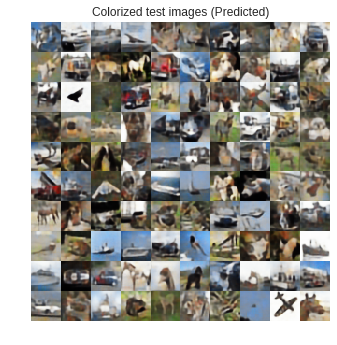

In [29]:
# predict the autoencoder output from test data
x_decoded = autoencoder.predict(x_test_gray)

# display the 1st 100 colorized images
imgs = x_decoded[:100]
imgs = imgs.reshape((10, 10, img_rows, img_cols, channels))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Colorized test images (Predicted)')
plt.imshow(imgs, interpolation='none')
plt.savefig('%s/colorized.png' % imgs_dir)
plt.show()